# Analysis on the imputed dataset

# Select and recode the variables

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Iterator, Tuple

import pandas as pd

# Recreate the SDT subset using the imputed WVS extract so downstream models share the same schema.
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
SOURCE_FILE = DATA_DIR / "WVS_imputed_median.csv"
OUTPUT_FILE = DATA_DIR / "lifesat_sdt_subset_imputed.csv"

TARGET_COLUMN = "Q49"  # Life satisfaction item
TARGET_RENAMED = "LifeSat"

COLUMN_GROUPS: dict[str, dict[str, str]] = {
    "com": {
        "Q47": "SHealth",
        "Q50": "FinSat",
        "Q56": "FinSat_ComParent",
        "Q142": "RiskUnemployed",
        "Q143": "EducationNextGen",
        # "Q275": "Education",
		# "Q279": "PaidEmployment",
		# "Q281": "OccupationalGroup",
		# "Q285": "ChiefWageEarner",
		# "Q286": "FamFin",
		# "Q287": "SocialStatus",
		# "Q288": "HouseholdSocialStatus",
    },
    "aut": {
        "Q48": "FreeChoice",
        "Q131": "Security",
        "Q146": "PublicSecurity_War",
        "Q147": "PublicSecurity_Terrorism",
        "Q148": "PublicSecurity_CivilWar",
        "Q251": "Democracy",
        "Q253": "HumanRights",
    },
    "rel": {
        "Q57": "Trust",
        "Q58": "Trust_Family",
        "Q59": "Trust_Neighbors",
        "Q60": "Trust_Acquaintances",
        "Q61": "Trust_Strangers",
        "Q62": "Trust_OtherReligion",
        "Q63": "Trust_OtherNationality",
        "Q94": "Membership_Religious",
        "Q95": "Membership_Sport",
        "Q96": "Membership_Art",
        "Q97": "Membership_LaborUnion",
        "Q98": "Membership_Political",
        "Q99": "Membership_Environmental",
        "Q100": "Membership_Professional",
        "Q101": "Membership_Charity",
        "Q102": "Membership_Consumer",
        "Q103": "Membership_SelfHelp",
        "Q104": "Membership_Women",
        "Q105": "Membership_Other",
        "Q164": "GodImportance",
        "Q171": "ReligiousAttendance",
        "Q172": "Pray",
        "Q254": "NationalPride",
        "Q255": "CloseToTown",
        "Q256": "CloseToRegion",
        "Q257": "CloseToCountry",
        "Q258": "CloseToContinent",
        "Q259": "CloseToWorld",
		# "Q269": "Citizenship",
		# "Q270": "NFamilyMembers",
		# "Q274": "NChildren"
    },
}

def column_pairs() -> Iterator[Tuple[str, str]]:
    for mapping in COLUMN_GROUPS.values():
        for source_column, renamed in mapping.items():
            yield source_column, renamed

predictor_pairs = list(column_pairs())
required_columns = [TARGET_COLUMN, *(source for source, _ in predictor_pairs)]

frame = pd.read_csv(SOURCE_FILE, usecols=required_columns)
rename_map = {TARGET_COLUMN: TARGET_RENAMED}
rename_map.update({source: renamed for source, renamed in predictor_pairs})
frame = frame.rename(columns=rename_map)
ordered_columns = [TARGET_RENAMED, *(renamed for _, renamed in predictor_pairs)]
frame = frame[ordered_columns]

frame.to_csv(OUTPUT_FILE, index=False)
print(f"Saved imputed SDT subset with {frame.shape[0]} rows to {OUTPUT_FILE.name}.")

Saved imputed SDT subset with 95800 rows to lifesat_sdt_subset_imputed.csv.


# Life Satisfaction: Descriptive Statistics
Summaries of the `LifeSat` target from `data/lifesat_sdt_subset_imputed.csv`.

In [2]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../data/lifesat_sdt_subset_imputed.csv")
df = pd.read_csv(DATA_PATH)

lifesat = pd.to_numeric(df["LifeSat"], errors="coerce")
lifesat_summary = lifesat.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
lifesat_summary_df = lifesat_summary.to_frame(name="LifeSat").T
lifesat_value_counts = lifesat.value_counts(dropna=False).sort_index()

display(lifesat_summary_df)
display(lifesat_value_counts.to_frame(name="count"))

,count,mean,std,min,10%,25%,50%,75%,90%,max
LifeSat,95800.0,7.066409,2.237507,1.0,4.0,6.0,7.0,9.0,10.0,10.0


,count
LifeSat,
1.0,2596
2.0,1403
3.0,3103
4.0,4426
5.0,11383
6.0,10857
7.0,16234
8.0,19545
9.0,10038


# Recoding the predictors
Reverse the predictors so that a higher score means a higher value of the construct.

In [3]:
reversed_vars = [
    "SHealth",
    "RiskUnemployed",
    "EducationNextGen",
    "Security",
    "HumanRights",
    "Trust_Family",
    "Trust_Neighbors",
    "Trust_Acquaintances",
    "Trust_Strangers",
    "Trust_OtherReligion",
    "Trust_OtherNationality",
    "ReligiousAttendance",
    "Pray",
    "NationalPride",
    "CloseToTown",
    "CloseToRegion",
    "CloseToCountry",
    "CloseToContinent",
    "CloseToWorld",
]
df_reversed = df.copy()
missing_reverse: list[str] = []

for column in reversed_vars:
    if column not in df_reversed.columns:
        missing_reverse.append(column)
        continue
    numeric = pd.to_numeric(df_reversed[column], errors="coerce")
    col_min = numeric.min()
    col_max = numeric.max()
    if pd.isna(col_min) or pd.isna(col_max):
        missing_reverse.append(column)
        continue
    # Recode by reversing the scale
    df_reversed[column] = col_min + col_max - numeric

print(f"Reversed {len(reversed_vars) - len(missing_reverse)} variables.")
if missing_reverse:
    print("Columns not processed:", ", ".join(missing_reverse))

Reversed 19 variables.


Recode the `FinSat_ComParent` (Financial Satisfaction Compared to Parents in the Past) variable so that a higher score means better off.

In [4]:
df_recoded = df_reversed.copy()

if "FinSat_ComParent" in df_recoded.columns:
    df_recoded["FinSat_ComParent"] = (
        pd.to_numeric(df_recoded["FinSat_ComParent"], errors="coerce")
        .replace({1: 3, 2: 1, 3: 2})    # 1 = worse off, 2 = same, 3 = better off
    )
    print("Re-coded FinSat_ComParent with custom mapping.")
else:
    print("FinSat_ComParent column not found; no recoding applied.")

Re-coded FinSat_ComParent with custom mapping.


Create dummy variable for `Trust` such that 1 = higher trust, 0 = lower trust.

In [5]:
df_recoded = df_recoded.copy()

if "Trust" in df_recoded.columns:
    trust_numeric = pd.to_numeric(df_recoded["Trust"], errors="coerce")
    trust_dummy = (trust_numeric == 1).astype("Int64")    # 1 = higher trust, 0 = lower trust
    trust_idx = df_recoded.columns.get_loc("Trust")
    df_recoded = df_recoded.drop(columns=["Trust"])
    df_recoded.insert(trust_idx, "Trust_dummy", trust_dummy) # type: ignore
    print("Created Trust_dummy and replaced Trust in the column order.")
else:
    print("Trust column not found; dummy not created.")

Created Trust_dummy and replaced Trust in the column order.


In [6]:
# Save the recoded dataset
df_recoded.to_csv(DATA_PATH.parent / "lifesat_sdt_subset_imputed_recoded.csv", index=False)

In [7]:
# Prepare data for modeling

numeric_df = df_recoded.apply(lambda col: pd.to_numeric(col, errors="coerce"))

predictor_cols = [col for col in numeric_df.columns if col != "LifeSat"]

predictor_summary = pd.DataFrame({
    "mean": numeric_df[predictor_cols].mean(),
    "std": numeric_df[predictor_cols].std(),
    "median": numeric_df[predictor_cols].median(),
    "IQR": numeric_df[predictor_cols].quantile(0.75) - numeric_df[predictor_cols].quantile(0.25),
    "missing": numeric_df[predictor_cols].isna().sum(),
})
display(predictor_summary)

# Handle missing data with listwise deletion
model_data = numeric_df.dropna(subset=["LifeSat", *predictor_cols])
rows_dropped = numeric_df.shape[0] - model_data.shape[0]
print(f"Dropped {rows_dropped} rows due to missing values (listwise deletion).")
print(f"Retained {model_data.shape[0]} rows for modeling.")

model_data = model_data.astype(float)

# Save the cleaned model-ready dataset
model_data.to_csv(DATA_PATH.parent / "lifesat_sdt_subset_imputed_model_data.csv", index=False)

,mean,std,median,IQR,missing
SHealth,3.813319,0.873778,4.0,1.0,0
FinSat,6.211399,2.420848,6.0,3.0,0
FinSat_ComParent,2.385438,0.762093,3.0,1.0,0
RiskUnemployed,2.810104,1.09075,3.0,2.0,0
EducationNextGen,2.90548,1.091112,3.0,2.0,0
FreeChoice,7.227203,2.247949,8.0,3.0,0
Security,2.992338,0.81021,3.0,1.0,0
PublicSecurity_War,2.098288,1.060014,2.0,2.0,0
PublicSecurity_Terrorism,2.085334,1.046021,2.0,2.0,0
PublicSecurity_CivilWar,2.263612,1.132109,2.0,2.0,0


Dropped 0 rows due to missing values (listwise deletion).
Retained 95800 rows for modeling.


# Linear Regression
Predicting `LifeSat` with variables from the three domains of Self-Determination Theory (SDT). 

In [8]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = model_data[predictor_cols]
y = model_data["LifeSat"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_sm = sm.add_constant(X_train, has_constant="add")
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                LifeSat   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     1348.
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:09:40   Log-Likelihood:            -1.5000e+05
No. Observations:               76640   AIC:                         3.001e+05
Df Residuals:                   76599   BIC:                         3.005e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Evaluate on test set
X_test_sm = sm.add_constant(X_test, has_constant="add")
predicted = ols_model.predict(X_test_sm)    

# Calculate MSE and RMSE on test set
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")

Test MSE: 2.942
Test RMSE: 1.715


## Multicollinearity Diagnostics
Variance inflation factors flag redundant predictors before interpreting coefficients.

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(X)
vif_data = pd.DataFrame({
    "feature": ["const", *predictor_cols],
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],  # type: ignore
})
display(vif_data)

,feature,VIF
0,const,134.977537
1,SHealth,1.142392
2,FinSat,1.295303
3,FinSat_ComParent,1.110766
4,RiskUnemployed,1.666897
5,EducationNextGen,1.758114
6,FreeChoice,1.170137
7,Security,1.154410
8,PublicSecurity_War,2.869033
9,PublicSecurity_Terrorism,2.975654


## Regression Diagnostics
Residual plots and influence checks highlight departures from linear assumptions.

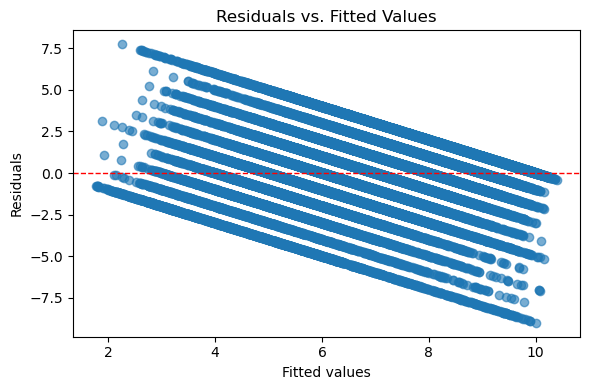

In [12]:
import matplotlib.pyplot as plt

# Residuals vs. fitted values
fitted_train = ols_model.fittedvalues
residuals = ols_model.resid
plt.figure(figsize=(6, 4))
plt.scatter(fitted_train, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.tight_layout()
plt.show()

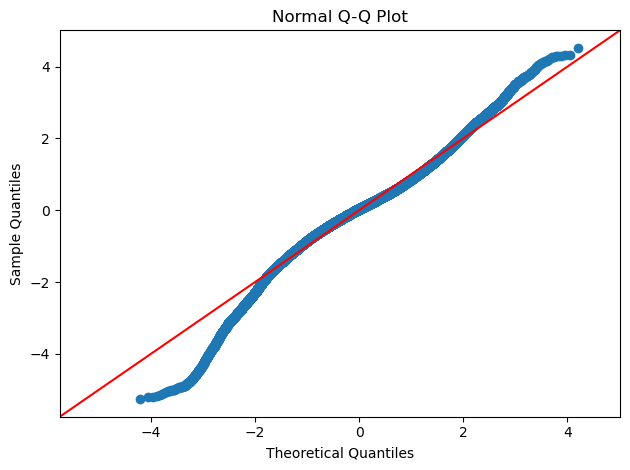

In [13]:
# Normal Q-Q plot of studentized residuals
influence = ols_model.get_influence()
studentized_residuals = influence.resid_studentized_internal
sm.qqplot(studentized_residuals, line="45", fit=True)
plt.title("Normal Q-Q Plot")
plt.tight_layout()
plt.show()

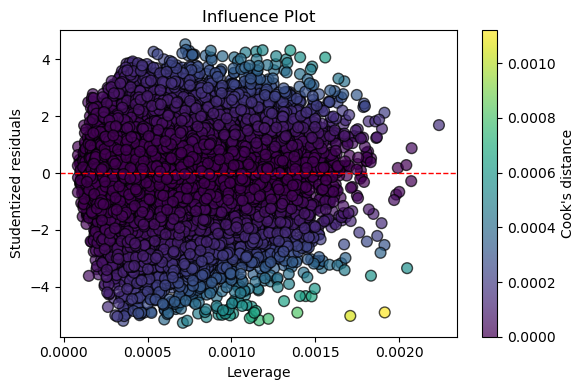

In [14]:
# Leverage vs. studentized residuals with Cook's distance
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]
n_obs = X_train_sm.shape[0]
plt.figure(figsize=(6, 4))
plt.scatter(leverage, studentized_residuals, c=cooks_d, cmap="viridis", s=60, edgecolor="k", alpha=0.7)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Leverage")
plt.ylabel("Studentized residuals")
plt.title("Influence Plot")
plt.colorbar(label="Cook's distance")
plt.tight_layout()
plt.show()

## Ridge and Lasso Regressions

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Standardize predictors for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Search candidate penalties on a log grid
alphas = np.logspace(-3, 3, 50)

# Ridge with 10-fold CV
ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_scaled, y_train)

# Lasso with 10-fold CV
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)


ridge_test_pred = ridge_cv.predict(X_test_scaled)
lasso_test_pred = lasso_cv.predict(X_test_scaled)


ridge_results = {
    "model": "Ridge",
    "alpha": ridge_cv.alpha_,
    "train_MSE": mean_squared_error(y_train, ridge_cv.predict(X_train_scaled)),
    "test_MSE": mean_squared_error(y_test, ridge_test_pred),
    "test_RMSE": np.sqrt(mean_squared_error(y_test, ridge_test_pred)),
    "n_nonzero_coefficients": np.sum(np.abs(ridge_cv.coef_) > 1e-8),
}


lasso_results = {
    "model": "Lasso",
    "alpha": lasso_cv.alpha_,
    "train_MSE": mean_squared_error(y_train, lasso_cv.predict(X_train_scaled)),
    "test_MSE": mean_squared_error(y_test, lasso_test_pred),
    "test_RMSE": np.sqrt(mean_squared_error(y_test, lasso_test_pred)),
    "n_nonzero_coefficients": np.sum(np.abs(lasso_cv.coef_) > 1e-8),
}


regularization_summary = pd.DataFrame([ridge_results, lasso_results])
display(regularization_summary.sort_values("test_MSE"))

,model,alpha,train_MSE,test_MSE,test_RMSE,n_nonzero_coefficients
0,Ridge,244.205309,2.934248,2.942392,1.715340,40
1,Lasso,0.002330,2.934528,2.942961,1.715506,36


# Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import numpy as np


rf_regressor = RandomForestRegressor(
    n_estimators=500,
    max_features=13,
    random_state=42,
    n_jobs=-1,
    oob_score=False,
    min_samples_leaf=2,
    bootstrap=True,
    max_depth=None,
    min_samples_split=2,
    criterion="squared_error",
)


cv_results = cross_validate(
    rf_regressor,
    X_train,
    y_train,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise",
)


cv_mse = -cv_results["test_score"]
cv_rmse = np.sqrt(cv_mse)
print(f"CV MSE (mean ± std): {cv_mse.mean():.3f} ± {cv_mse.std():.3f}")
print(f"CV RMSE (mean ± std): {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


rf_regressor.fit(X_train, y_train)
rf_test_pred = rf_regressor.predict(X_test)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(rf_test_mse)
print(f"Test MSE: {rf_test_mse:.3f}")
print(f"Test RMSE: {rf_test_rmse:.3f}")

CV MSE (mean ± std): 2.808 ± 0.082
CV RMSE (mean ± std): 1.675 ± 0.025
Test MSE: 2.796
Test RMSE: 1.672


,feature,importance
1,FinSat,0.271470
5,FreeChoice,0.147328
0,SHealth,0.046957
10,Democracy,0.040069
2,FinSat_ComParent,0.027386
32,ReligiousAttendance,0.027116
31,GodImportance,0.023492
33,Pray,0.023163
6,Security,0.020301
11,HumanRights,0.019224


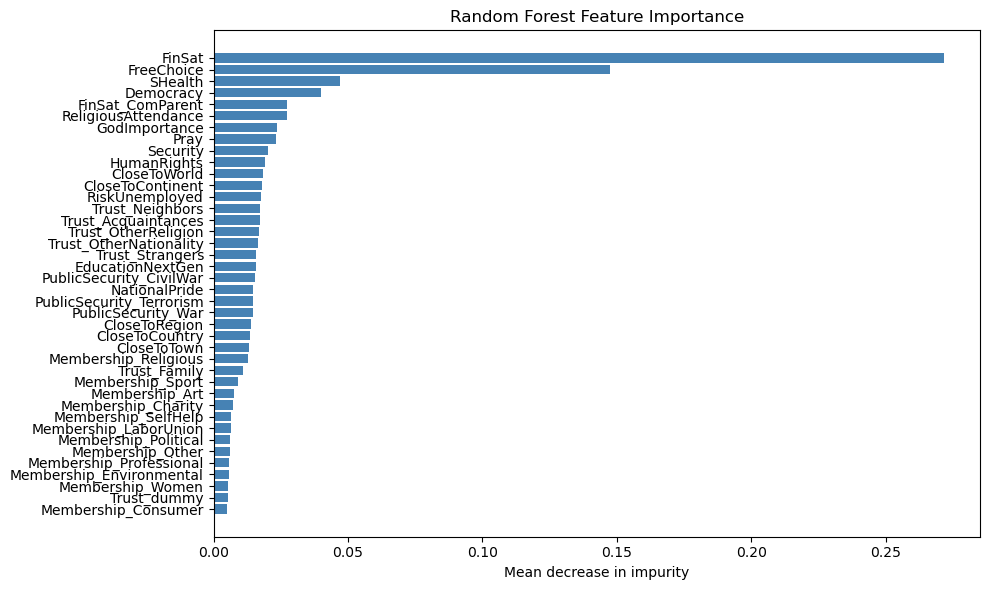

In [17]:
# Plot feature importance

import pandas as pd

feature_importance = pd.DataFrame(
    {
        "feature": predictor_cols,
        "importance": rf_regressor.feature_importances_,
    }
).sort_values("importance", ascending=False)

display(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"], feature_importance["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# Refit the full dataset with Random Forest
Given the lowest test MSE given by the Cross-Validated Random Forest (CV-RF) model, we will now proceed to fit the full dataset (*n* = 95800) using the CV-RF model, with the aim of maximizing the use of observations.

,feature,importance
1,FinSat,0.271225
5,FreeChoice,0.148016
0,SHealth,0.046930
10,Democracy,0.039966
2,FinSat_ComParent,0.027466
32,ReligiousAttendance,0.027155
31,GodImportance,0.023430
33,Pray,0.023273
6,Security,0.020045
11,HumanRights,0.019200


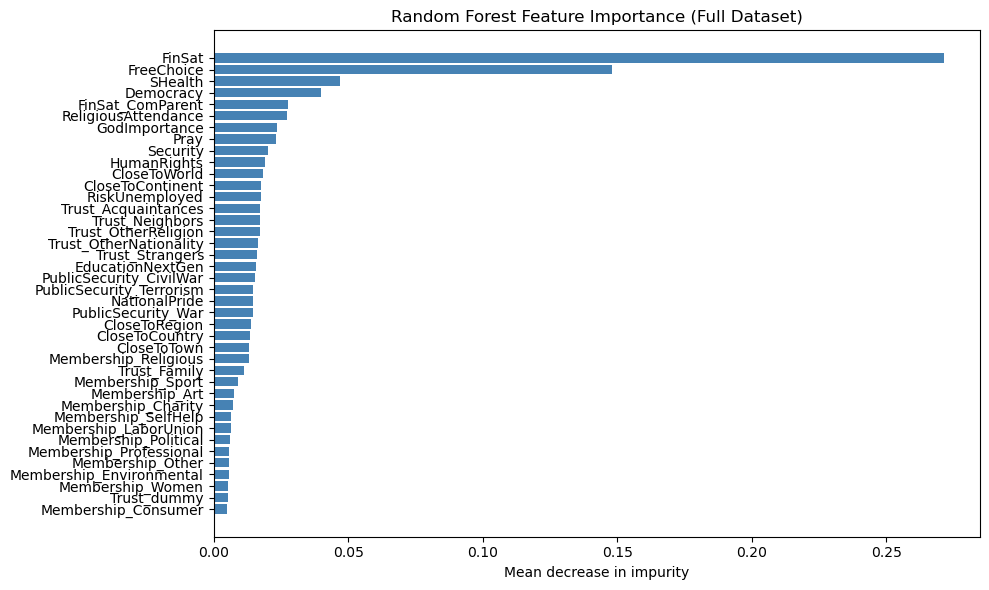

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd

# Refit the tuned random forest using all available observations
rf_regressor_full = RandomForestRegressor(
    n_estimators=500,
    max_features=13,
    random_state=42,
    n_jobs=-1,
    oob_score=False,
    min_samples_leaf=2,
    bootstrap=True,
    max_depth=None,
    min_samples_split=2,
    criterion="squared_error",
)

rf_regressor_full.fit(X, y)

full_feature_importance = pd.DataFrame(
    {
        "feature": predictor_cols,
        "importance": rf_regressor_full.feature_importances_,
    }
).sort_values("importance", ascending=False)

display(full_feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(full_feature_importance["feature"], full_feature_importance["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest Feature Importance (Full Dataset)")
plt.tight_layout()
plt.savefig("../output/rf_reg_feature_importance_full_imputed.png")
plt.show()

# Discretization of DV
We also explore the results when we discretize the DV `LifeSat` into three bins:
- Unsatisfied: Scores 1–4
- Somewhat satisfied: Scores 5–7
- Highly satisfied: Scores 8–10

In [19]:
lifeSat_bins = pd.cut(
    model_data["LifeSat"],
    bins=[0, 4, 7, 10],
    labels=["Unsatisfied", "Somewhat satisfied", "Highly satisfied"],
    include_lowest=True,
    right=True,
    ordered=True,
 )
lifesat_idx = model_data.columns.get_loc("LifeSat")
if "LifeSat_binned" not in model_data.columns:
    model_data.insert(lifesat_idx + 1, "LifeSat_binned", lifeSat_bins)
else:
    model_data["LifeSat_binned"] = lifeSat_bins
print("LifeSat_binned counts:")
print(model_data["LifeSat_binned"].value_counts().sort_index())

# Save the updated model data with binned LifeSat
model_data.to_csv(DATA_PATH.parent / "lifesat_sdt_model_data_binned_imputed.csv", index=False)

LifeSat_binned counts:
LifeSat_binned
Unsatisfied           11528
Somewhat satisfied    38474
Highly satisfied      45798
Name: count, dtype: int64


## Multinomial Logistic Regression

In [20]:
from statsmodels.discrete.discrete_model import MNLogit

# Align the categorical outcome with X_train indices
y_train_mult = model_data.loc[X_train.index, "LifeSat_binned"].astype("category")
category_order = list(y_train_mult.cat.categories)
print("MNLogit category order:", category_order)

train_valid_idx = y_train_mult.dropna().index
X_train_mult = X_train.loc[train_valid_idx]
y_train_mult = y_train_mult.loc[train_valid_idx]
X_train_mult_sm = sm.add_constant(X_train_mult, has_constant="add")
y_train_codes = y_train_mult.cat.codes

mnlogit_model = MNLogit(y_train_codes, X_train_mult_sm)
mnlogit_result = mnlogit_model.fit(method="newton", maxiter=100, disp=False)
print(mnlogit_result.summary())

MNLogit category order: ['Unsatisfied', 'Somewhat satisfied', 'Highly satisfied']
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                76640
Model:                        MNLogit   Df Residuals:                    76558
Method:                           MLE   Df Model:                           80
Date:                Mon, 17 Nov 2025   Pseudo R-squ.:                  0.2295
Time:                        14:45:17   Log-Likelihood:                -57518.
converged:                       True   LL-Null:                       -74648.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     y=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -3.3362      0.142    -23.463      0.000      -3.615      -3.058
SHealth

Exception ignored in: <function ResourceTracker.__del__ at 0x11a011bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x108c81bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


,metric,value
0,accuracy,0.656681
1,weighted_f1,0.647399
2,matthews_corrcoef,0.405335
3,roc_auc_weighted,0.795807


AUC (Unsatisfied vs rest): 0.864
AUC (Somewhat satisfied vs rest): 0.743
AUC (Highly satisfied vs rest): 0.823


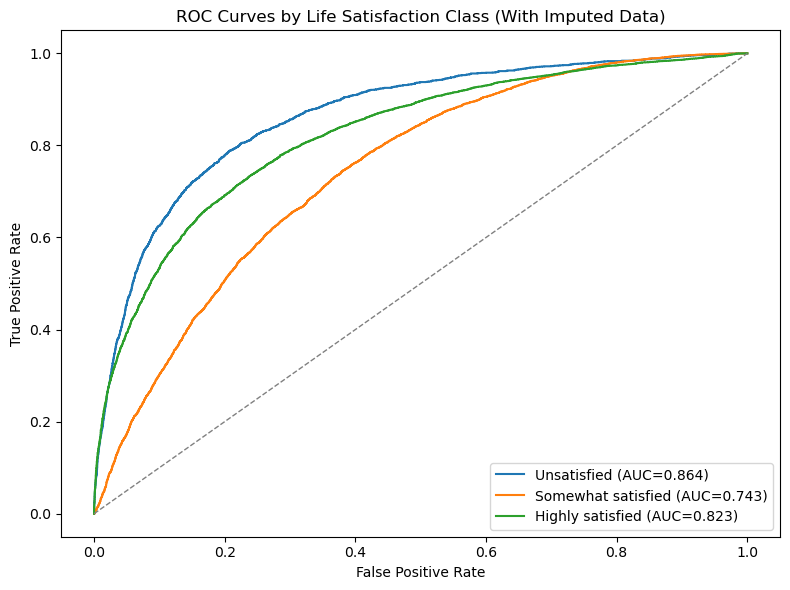


ROC curve points for Unsatisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000000,0.000433,0.934410
2,0.000000,0.002166,0.893618
3,0.000059,0.002166,0.889840
4,0.000059,0.004766,0.877161



ROC curve points for Somewhat satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000087,0.000000,0.784577
2,0.000174,0.000000,0.779421
3,0.000174,0.000261,0.762140
4,0.000261,0.000261,0.759539



ROC curve points for Highly satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.0000,0.000000,inf
1,0.0000,0.000109,0.968787
2,0.0000,0.006211,0.951106
3,0.0001,0.006211,0.951086
4,0.0001,0.013185,0.945034


Exception ignored in: <function ResourceTracker.__del__ at 0x107165bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106075bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1056e9bc0>
Traceback (most recent call last

In [21]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Prepare test set for evaluation
y_test_mult = model_data.loc[X_test.index, "LifeSat_binned"].astype("category")
y_test_mult = y_test_mult.cat.set_categories(category_order, ordered=True)

test_valid_idx = y_test_mult.dropna().index
X_test_mult = X_test.loc[test_valid_idx]
y_test_mult = y_test_mult.loc[test_valid_idx]
X_test_mult_sm = sm.add_constant(X_test_mult, has_constant="add")
y_test_codes = y_test_mult.cat.codes

test_probabilities = mnlogit_result.predict(X_test_mult_sm)
pred_codes = test_probabilities.to_numpy().argmax(axis=1)

accuracy = accuracy_score(y_test_codes, pred_codes)
weighted_f1 = f1_score(y_test_codes, pred_codes, average="weighted")
mcc = matthews_corrcoef(y_test_codes, pred_codes)

y_test_binarized = label_binarize(y_test_codes, classes=range(len(category_order)))
roc_auc_weighted = roc_auc_score(
    y_test_binarized,
    test_probabilities.to_numpy(),
    average="weighted",
    multi_class="ovr",
)
roc_auc_per_class = roc_auc_score(
    y_test_binarized,
    test_probabilities.to_numpy(),
    average=None,
    multi_class="ovr",
)

metrics_summary = pd.DataFrame(
    {
        "metric": ["accuracy", "weighted_f1", "matthews_corrcoef", "roc_auc_weighted"],
        "value": [accuracy, weighted_f1, mcc, roc_auc_weighted],
    }
)
display(metrics_summary)

for class_name, auc_val in zip(category_order, roc_auc_per_class):
    print(f"AUC ({class_name} vs rest): {auc_val:.3f}")

roc_curves = {}
plt.figure(figsize=(8, 6))
for class_idx, class_name in enumerate(category_order):
    fpr, tpr, thresholds = roc_curve(
        y_test_binarized[:, class_idx],
        test_probabilities.to_numpy()[:, class_idx],
    )
    roc_curves[class_name] = pd.DataFrame(
        {
            "fpr": fpr,
            "tpr": tpr,
            "threshold": thresholds,
        }
)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc_per_class[class_idx]:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Life Satisfaction Class (With Imputed Data)")
plt.legend()
plt.tight_layout()
plt.savefig("../output/roc_curves_lifesat_multinomial_imputed.png")
plt.show()

# Save the plotted ROC curves figure
output_dir = Path("../output/")
output_dir.mkdir(parents=True, exist_ok=True)

for class_name, curve_df in roc_curves.items():
    print(f"\nROC curve points for {class_name} (first 5 rows):")
    display(curve_df.head())

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
 )
from sklearn.preprocessing import label_binarize

# Prepare training data with valid LifeSat_binned labels
y_train_class = model_data.loc[X_train.index, "LifeSat_binned"].astype("category") # type: ignore
train_valid_idx = y_train_class.dropna().index
X_train_class = X_train.loc[train_valid_idx]
y_train_class = y_train_class.loc[train_valid_idx]
category_order = list(y_train_class.cat.categories)

rf_classifier = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features="sqrt",    # typically used for classification
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
 )

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ["accuracy", "f1_weighted"]

cv_results_clf = cross_validate(
    rf_classifier,
    X_train_class,
    y_train_class,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
 )

cv_summary = pd.DataFrame({
    "metric": scoring,
    "train_mean": [cv_results_clf[f"train_{metric}"].mean() for metric in scoring],
    "train_std": [cv_results_clf[f"train_{metric}"].std() for metric in scoring],
    "test_mean": [cv_results_clf[f"test_{metric}"].mean() for metric in scoring],
    "test_std": [cv_results_clf[f"test_{metric}"].std() for metric in scoring],
}).round(3)
display(cv_summary)

rf_classifier.fit(X_train_class, y_train_class)
feature_importance_clf = pd.Series(
    rf_classifier.feature_importances_, index=X_train_class.columns
 ).sort_values(ascending=False)
display(feature_importance_clf.head(10).to_frame(name="importance"))

# Evaluate on held-out test set for context
y_test_class = model_data.loc[X_test.index, "LifeSat_binned"].astype("category")
y_test_class = y_test_class.cat.set_categories(category_order, ordered=True)
test_valid_idx = y_test_class.dropna().index
X_test_class = X_test.loc[test_valid_idx]
y_test_class = y_test_class.loc[test_valid_idx]

test_probabilities = rf_classifier.predict_proba(X_test_class)
proba_df = pd.DataFrame(
    test_probabilities,
    columns=rf_classifier.classes_,
    index=X_test_class.index
).reindex(columns=category_order, fill_value=0.0)
test_predictions = pd.Categorical(
    rf_classifier.predict(X_test_class), categories=category_order, ordered=True
 )

y_test_codes = y_test_class.cat.codes
accuracy = accuracy_score(y_test_class, test_predictions)
weighted_f1 = f1_score(y_test_class, test_predictions, average="weighted", zero_division=0)
mcc = matthews_corrcoef(y_test_class, test_predictions)

y_test_binarized = label_binarize(y_test_codes, classes=range(len(category_order)))
roc_auc_weighted = roc_auc_score(
    y_test_binarized,
    proba_df.to_numpy(),
    average="weighted",
    multi_class="ovr",
 )
roc_auc_per_class = roc_auc_score(
    y_test_binarized,
    proba_df.to_numpy(),
    average=None,
    multi_class="ovr",
 )

metrics_summary = pd.DataFrame(
    {
        "metric": ["accuracy", "weighted_f1", "matthews_corrcoef", "roc_auc_weighted"],
        "value": [accuracy, weighted_f1, mcc, roc_auc_weighted],
    }
 )
display(metrics_summary)

for class_name, auc_val in zip(category_order, roc_auc_per_class):
    print(f"AUC ({class_name} vs rest): {auc_val:.3f}")

print("Random Forest classification report (test set):")
print(
    classification_report(
        y_test_class, test_predictions, target_names=category_order, zero_division=0
    )
)

# Confusion matrix with totals
confusion_df = pd.crosstab(
    y_test_class,
    test_predictions,
    rownames=["Actual"],
    colnames=["Predicted"],
    dropna=False,
 ).reindex(index=category_order, columns=category_order, fill_value=0)
confusion_df["Total"] = confusion_df.sum(axis=1)
total_row = pd.DataFrame(confusion_df.sum(axis=0)).T
total_row.index = ["Total"]
confusion_with_totals = pd.concat([confusion_df, total_row])
display(confusion_with_totals)

,metric,train_mean,train_std,test_mean,test_std
0,accuracy,0.973,0.0,0.691,0.003
1,f1_weighted,0.972,0.0,0.684,0.003


,importance
FinSat,0.190547
FreeChoice,0.128927
Democracy,0.045794
SHealth,0.037411
ReligiousAttendance,0.032351
GodImportance,0.032174
Pray,0.029843
FinSat_ComParent,0.024386
RiskUnemployed,0.022816
CloseToWorld,0.022782


,metric,value
0,accuracy,0.690084
1,weighted_f1,0.683987
2,matthews_corrcoef,0.466154
3,roc_auc_weighted,0.828012


AUC (Unsatisfied vs rest): 0.888
AUC (Somewhat satisfied vs rest): 0.788
AUC (Highly satisfied vs rest): 0.846
Random Forest classification report (test set):
                    precision    recall  f1-score   support

       Unsatisfied       0.74      0.78      0.76      9177
Somewhat satisfied       0.63      0.68      0.66      7675
  Highly satisfied       0.68      0.37      0.48      2308

          accuracy                           0.69     19160
         macro avg       0.69      0.61      0.63     19160
      weighted avg       0.69      0.69      0.68     19160



Predicted,Unsatisfied,Somewhat satisfied,Highly satisfied,Total
Unsatisfied,858,1091,359,2308
Somewhat satisfied,281,5226,2168,7675
Highly satisfied,119,1920,7138,9177
Total,1258,8237,9665,19160


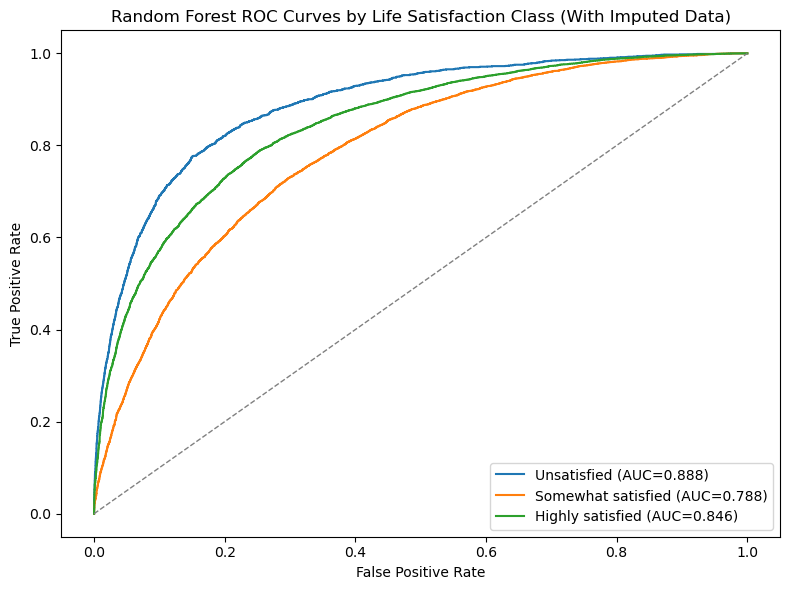


ROC curve points for Unsatisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000000,0.000433,0.935785
2,0.000000,0.005199,0.871729
3,0.000059,0.005199,0.865593
4,0.000059,0.019064,0.798096



ROC curve points for Somewhat satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.0,0.000000,inf
1,0.0,0.000521,0.999613
2,0.0,0.000782,0.995692
3,0.0,0.001954,0.956096
4,0.0,0.002215,0.954811



ROC curve points for Highly satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.0,0.000000,inf
1,0.0,0.000109,0.999400
2,0.0,0.006429,0.973623
3,0.0,0.006647,0.973226
4,0.0,0.006756,0.973210


In [23]:
from sklearn.metrics import roc_curve

# Plot ROC curves for the random forest classifier
roc_curves_rf: dict[str, pd.DataFrame] = {}
roc_auc_per_class_rf = roc_auc_score(
    y_test_binarized, proba_df.to_numpy(), average=None, multi_class="ovr"
 )

fig, ax = plt.subplots(figsize=(8, 6))
for class_idx, class_name in enumerate(category_order):
    fpr, tpr, thresholds = roc_curve(
        y_test_binarized[:, class_idx], proba_df.to_numpy()[:, class_idx]
    )
    roc_curves_rf[class_name] = pd.DataFrame(
        {"fpr": fpr, "tpr": tpr, "threshold": thresholds}
    )
    ax.plot(
        fpr,
        tpr,
        label=f"{class_name} (AUC={roc_auc_per_class_rf[class_idx]:.3f})",
    )

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", linewidth=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Random Forest ROC Curves by Life Satisfaction Class (With Imputed Data)")
ax.legend()
fig.tight_layout()

output_dir = Path("../output/")
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / "roc_curves_random_forest_imputed.png")
plt.show()

for class_name, curve_df in roc_curves_rf.items():
    print(f"\nROC curve points for {class_name} (first 5 rows):")
    display(curve_df.head())

## Refit the full dataset with Random Forest
Because of the slightly better classification performance by the Cross-Validated Random Forest model, we will fit the full dataset (*n* = 60806) using the random forest model.

In [ ]:
# Refit the tuned random forest classifier on the full dataset
model_data_class = model_data.dropna(subset=["LifeSat_binned"]).copy()
X_full_class = model_data_class[predictor_cols]
y_full_class = model_data_class["LifeSat_binned"].astype("category")
category_order_full = list(y_full_class.cat.categories)

print(
    f"Refitting random forest classifier on {X_full_class.shape[0]} observations and "
    f"{X_full_class.shape[1]} predictors."
 )

rf_classifier_full = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
 )
rf_classifier_full.fit(X_full_class, y_full_class)

feature_importance_full = pd.DataFrame(
    {
        "feature": X_full_class.columns,
        "importance": rf_classifier_full.feature_importances_,
    }
).sort_values("importance", ascending=False).reset_index(drop=True)
display(feature_importance_full)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_full["feature"], feature_importance_full["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest Feature Importance (Full Dataset, With Imputed Data)")
plt.tight_layout()
plt.savefig("../output/rf_class_feature_importance_full_imputed.png")
plt.show()